Kaggle "Ames House Price: Advanced Reagression Techniques" competion to predict the house prices 
Using the 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, the challenge is to predict the final price of each home. 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques

    by Adarsh Namala
    adarsh.namala@gmail.com

In [28]:
import pandas as pd
import os 
import numpy as np
import seaborn as sns
import ggplot as gg
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [71]:
from sklearn.feature_selection import SelectKBest,f_regression,VarianceThreshold
from sklearn.linear_model import ridge_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from scipy import stats

Define the verious functions needed

In [30]:
def generate_trans_data(temp_train_data,temp_test_data,int_cols,dummy_cols):
    """
    Function to transforms the categorical data into dummy columns
    """
    temp_train_df = temp_train_data.copy()
    temp_test_df = temp_test_data.copy()
    # set the Id as index
    temp_train_df = temp_train_df.set_index('Id',drop=False)
    temp_test_df = temp_test_df.set_index('Id',drop=False)
    
    # delete SalePrice and Id from the data. We need to keep the index the same
    temp_data = pd.concat([temp_train_df,temp_test_df]).loc[:,temp_train_df.columns]
    
    # drop ID and Sales Price
    drop_cols = ['SalePrice','Id']
    temp_data = temp_data.drop(drop_cols,axis=1)
    
    # if SalesPrice in int_cols, remove SalePrice
    temp_int_cols = list(set(int_cols) - set(['SalePrice']))
    missing_cols = list(set(temp_data.columns) - set(temp_int_cols + dummy_cols))
    if len(missing_cols)> 0:
        print "Columns not used:%s" %(missing_cols)
    
    select_dtype_dummy_cols = dummy_cols
    if len(dummy_cols) > 0:
        # for get_dummies, if its a single variable, it needs to be a string.
        if len(dummy_cols) == 1:
            dummy_cols = dummy_cols[0]

        # get the dummies. split the dummy columns into int_flt and string. for the float columns, we need to 
        # handle the null values so that the values are in int so that we don't get dummies like GarageCars_2.0 which would cause 
        # a mismatch in the column names of train_df and test_df
        
        # for select_dtypes if its a single dummy_cols value it need to be a list
        dummy_int_flt_cols = temp_data[select_dtype_dummy_cols].select_dtypes(include=[np.int64,np.float64]).columns.tolist()
        temp_data.loc[:,dummy_int_flt_cols] = temp_data[dummy_int_flt_cols].fillna(-1).astype(int).astype(str).replace('-1',np.nan)

        temp_df = pd.concat([temp_data[temp_int_cols].fillna(0),
                pd.get_dummies(temp_data[dummy_cols])],axis=1)
   
    else:
        temp_df = temp_data[temp_int_cols].fillna(0)
    
    train_trans_df = temp_df.loc[temp_train_df.index,:]
    test_trans_df = temp_df.loc[temp_test_df.index,:]
    # add the SalePrice to train_trans_df
    train_trans_df.loc[:,'SalePrice'] = temp_train_df['SalePrice']
    return train_trans_df, test_trans_df

In [31]:
def plot_pairplots(data_df,xvars_lst,y_var,plots_perrow=3):
    "Function to plot pairplots for the various xvars gainst a fied y variable"
    var_len = len(xvars_lst)
    req_ncols = plots_perrow
    req_rows = np.int(np.ceil(var_len/float(req_ncols)))
    start_idx = 0    
    for xi in range(0,req_rows):
        end_idx = start_idx + req_ncols
        temp_xvars = xvars_lst[start_idx:end_idx]
        sns.pairplot(data_df,x_vars=temp_xvars,y_vars=y_var,aspect=1.5,size=3)
        start_idx = start_idx + req_ncols

In [32]:
def plot_cat_graphs(data_df, xcols_lst,y_col,plots_per_row=4,plot_type='pointplot',plot_count=False):
    """
    Function to plots pointplots/boxplot/stripplot for various xcols against a fixed y variable
    """
    if plot_count:
        print "Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group."
    ncols = plots_per_row
    for xstart in range(0,int(np.ceil(len(xcols_lst)/float(ncols)))):
        # set the start and end for each iteration
        xstart = xstart * ncols
        end = xstart + ncols
        end = end if end <= len(xcols_lst) else len(xcols_lst)
        # get the list of req cols
        col_lst = xcols_lst[xstart:end]
        # set the number of plots in each row
        temp_ncols = len(col_lst)
        # create the subplots
        f,axes = plt.subplots(1,temp_ncols,figsize=(20,5),sharey=True)
        for i,xcol in enumerate(col_lst):
            temp_ax = axes[i] if temp_ncols > 1 else axes
            if plot_type == 'pointplot':
                sns.pointplot(xcol,y_col,data=data_df,ax= temp_ax)
            elif plot_type =='boxplot':
                sns.boxplot(xcol,y_col,data=data_df,ax= temp_ax)
            elif plot_type =='stripplot':
                sns.stripplot(xcol,y_col,data=data_df,ax= temp_ax)
            plt.setp(temp_ax.get_xticklabels(),rotation='vertical',size=13)
            
            if plot_count:
                # If xcol is a string then we need to convert it to numeric for count_nonzero to work ints. 
                # we start the dict from 1 since the function is count_nonzero
                xdict= dict(zip(data_df[xcol].unique().tolist(),range(1,len(data_df[xcol].unique())+1)))
                temp_ax_bar = temp_ax.twinx()
                x =sns.barplot(data_df[xcol],data_df[xcol].replace(xdict),estimator=np.count_nonzero,ax=temp_ax_bar,ci=None,
                                          facecolor='none',linewidth=0.7)
                temp_ax_bar.set_yticks([])
                temp_ax_bar.set_ylabel('')

In [33]:
def split_data_run_rf(train_df,train_trans_df,dep_col,split_size,rf_clf,drop_cols_lst='',top_feat=10,getscore=True):
    
    """
    Function to split  the data for training and validation, train the data on the given RandomForest algorithm and predict
    on the test set
    params:
        1) train_df: The original data. Merge the prediction and error. This is for analysis.
        2) train_trans_df: The transformed data used for training and validating the model.
    """
    
    #drop the required columns
    if len(drop_cols_lst) >0:
        temp_train_df = train_trans_df.drop(drop_cols_lst,axis=1)
    else:
        temp_train_df = train_trans_df.copy()        
    # split the data for training and testing
    temp_train_out_df = train_df.copy()
    X_train,X_test,y_train,y_test = train_test_split(temp_train_df.drop(dep_col,axis=1),temp_train_df[dep_col],
                                                     test_size=split_size,random_state=1985)
    rf_clf = rf_clf.fit(X_train,y_train)
    
    # if the splitsize is greater then 0 then use X_test else use X_train
    test_x,test_y =( X_test,y_test) if len(y_test)>0 else (X_train,y_train)
    
    pred_val = rf_clf.predict(test_x)    
    
    if getscore:
        print "The LogRMSE of prediction is:%0.4f"  %(mean_squared_error(np.log(test_y),np.log(pred_val))**0.5)
    
    feat_df = pd.DataFrame(zip(X_train.columns,rf_clf.feature_importances_),columns=['col','val']).sort_values('val',
                                                                                                ascending=False)
    
    print "Top 10 Feat Importance variables:\n%s" %(feat_df.head(top_feat))
    
    # combined the predicted value to the test_x
    # get the index of test_x
    req_idx = test_x.index
    temp_train_out_df = temp_train_out_df.loc[req_idx,:]
    temp_train_out_df['predicted'] = pred_val
    temp_train_out_df['residual'] = temp_train_out_df[dep_col] - temp_train_out_df['predicted']
    
    return temp_train_out_df,rf_clf

def get_combos(data_df,cat_col,dep_col,pval_cutoff=0.05,req_ax=None):
    """
    Function which caluclates the ANOVA of groups in a variable.
    This will help in binning/combining simlar groups before modeling
    """
    
    # get cat_col unique values, 
    idx = data_df.groupby(cat_col)[dep_col].mean().sort_values(ascending=True).index.tolist()
#     xplt = data_df.groupby(cat_col)[dep_col].mean().sort_values().plot(kind='bar')
    # get the values of each group 
    idx_vals = data_df.groupby(cat_col).apply(lambda x:x[dep_col].values)
    
    # for each idx values...get the anova
    start = 0
    end = 1
    combo = list()
    prefix = cat_col
    grp_no = 1
    
    while end <= len(idx):
        # we add 1 since numpy indexing is not right inclusive
        temp_idx = idx[start:end+1]
        # get the varience pvalue of the groups
        pval = stats.f_oneway(*(np.array(idx_vals[temp_idx]))).pvalue
        # check if the p value is significant or not
        if pval < pval_cutoff: # Reject null hypothesis. We need to exclude the last last idx from the grp
            # since the alternate hypo holds, we exclude the last index to the group
            temp_combo = temp_idx[:-1]
            # create a dict
            temp_combo = zip(temp_combo,[prefix+'_'+str(grp_no)]*len(temp_combo))
            combo = combo + [temp_combo]
            # start checking for the next group starting with the last idx
            start = end
            end = start+1
            grp_no = grp_no +  1
        else:
            temp_combo = temp_idx
            end = end+1
            
            if end == len(idx):
                # reached end of the list, since there is no significant varaince between groups, we add them to the combo
                temp_combo = zip(temp_combo,[prefix+'_'+str(grp_no)]*len(temp_combo))
                combo = combo + [temp_combo]
    
    # flatten the values
    combo = [subitem for item in combo for subitem in item]
    
    # check if the laxt index is in the list. If not, add it to the list
    temp_idx = [a for a,b in combo]
    if len(temp_idx) < len(idx):
        # add the last idx
#         grp_no = grp_no+1
        combo = combo + [(idx[-1],prefix+'_'+str(grp_no))]
    
    temp_idx = [a for a,b in combo]
    if len(temp_idx) < len(idx):
        print list(set(idx) - set(temp_idx))
        print temp_idx
        raise ValueError("Check function")
    
    temp_mean = data_df.groupby(cat_col)[dep_col].mean().sort_values().reset_index()
    # map the dict
    temp_mean['temp_grp'] = temp_mean[cat_col].map(dict(combo))
    # convert cat col to string so that sns does not sort the xlabels
#     temp_mean.loc[:,cat_col] = temp_mean[cat_col].astype(str)
    x = sns.barplot(cat_col,dep_col,hue='temp_grp',data=temp_mean,ax=req_ax,order=temp_mean[cat_col].unique())
#     req_ax.legend_.remove()
    plt.setp(req_ax.get_xticklabels(),rotation='vertical')
    x = plt.xticks(rotation='vertical')    
    
    return combo

def get_combos_wraper(data_df,cat_col_lst,dep_col,pval_cutoff=0.05):
    """
    wrapper function fot the get_combos function. This will call the get_combos function for each variable in the cat_col_lst
    """
    
    # determine the shape of the subplots
    var_len = len(cat_col_lst)
    req_ncols = 3
    req_nrows = int(np.ceil(var_len/float(req_ncols)))
    
    combos_lst = list()
    
    # for each row create a row subplot
    for xrow in range(0,req_nrows):
        start = xrow*req_ncols
        end = start + req_ncols
        temp_cat_cols = cat_col_lst[start:end]
        if len(temp_cat_cols) < req_ncols:
            req_ncols = len(temp_cat_cols)
        
        y,axes = plt.subplots(nrows=1,ncols=req_ncols,figsize=(20,5))
        for xi,xvar in enumerate(temp_cat_cols):
            # is there is aonly a single plot, then we cannot index the axes.Handle accordingly
            if len(temp_cat_cols) >1:
                temp_ax = axes[xi]
            else:
                temp_ax = axes
            temp_combo = get_combos(data_df,xvar,dep_col,pval_cutoff,req_ax=temp_ax)
            combos_lst = combos_lst + [(xvar,temp_combo)]    
        
    return combos_lst

In [34]:
#read the data
loc_dir = "C:\\Users\\206445860\\Documents\\Adarsh\\Kaggle\\HousePrices\\"
train_file = loc_dir + 'train.csv'
test_file = loc_dir + 'test.csv'

In [35]:
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

In [36]:
# get the dtypes
xvals = train_df.dtypes.reset_index().groupby(0)['index'].unique()
for xi,y in enumerate(xvals):
    print "\n****dtype:%s****" %(xvals.index[xi])
    print xvals[xi]



****dtype:int64****
['Id' 'MSSubClass' 'LotArea' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'BsmtFinSF1' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath'
 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr' 'KitchenAbvGr'
 'TotRmsAbvGrd' 'Fireplaces' 'GarageCars' 'GarageArea' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea'
 'MiscVal' 'MoSold' 'YrSold' 'SalePrice']

****dtype:float64****
['LotFrontage' 'MasVnrArea' 'GarageYrBlt']

****dtype:object****
['MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'LandSlope' 'Neighborhood' 'Condition1' 'Condition2'
 'BldgType' 'HouseStyle' 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd'
 'MasVnrType' 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC'
 'CentralAir' 'Electrical' 'KitchenQual' 'Functional' 'FireplaceQu'
 'GarageType' 'GarageFinis

In [37]:
# seperate the columns based on dtype
int_cols = train_df.select_dtypes(include=[np.int64,np.float64]).columns.tolist()
str_cols = train_df.select_dtypes(include=[np.object]).columns.tolist()

# remove 'Id' from int_cols
int_cols.remove('Id')

In [40]:
print train_df.shape, test_df.shape

 (1460, 81) (1459, 80)


In [41]:
# set the id as index
train_df.set_index('Id',drop=False,inplace=True)
test_df.set_index('Id',drop=False,inplace=True)

In [42]:
# check for null values in the data
train_null = train_df.isnull().sum()
print "Percentage of null values in the training dataset:\n%s" %(((train_null[train_null >0])*100/\
                                                                  len(train_df)).sort_values(ascending=False))

Percentage of null values in the training dataset:
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64


In [43]:
# Get those columns where the null values >= 30%
null_cutoff = 0.3
null_train_cols_high = train_null[train_null/len(train_df) > null_cutoff].index.tolist()
print "Columns that have atleast %i percent null values:%s" %(null_cutoff*100,null_train_cols_high)

Columns that have atleast 30 percent null values:['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


Based on the variance of the variable w.r.t to dependable variable, we will handle the null values

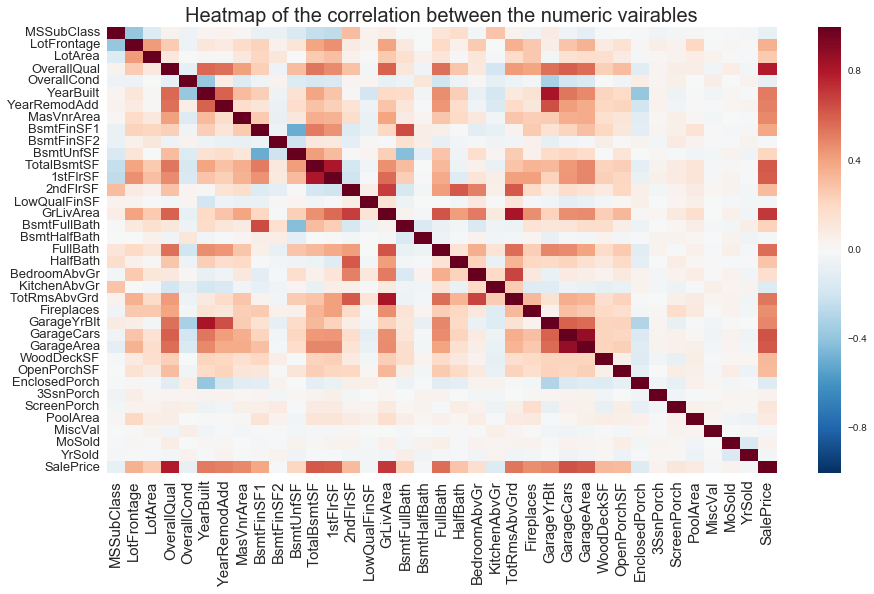

In [46]:
#check the correlation of the int_Cols
plt.figure(figsize=(15,8))

x = sns.heatmap(train_df[int_cols].corr())
plt.title("Heatmap of the correlation between the numeric vairables",size=20)
x= plt.xticks(size=15)
x = plt.yticks(size=13)

From the heat map, we can see that OverallQual, TotalBsmtSF, GrLiveArea, GarageCars, GarageArea have a significant positive impact on SalePrice. 

In [47]:
# split the int_cols into continuous and count/rank variables
int_ordinal_cols = ['MSSubClass','OverallQual','OverallCond','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd','MoSold',
                    'GarageCars','Fireplaces','FullBath','BsmtFullBath','BsmtHalfBath','HalfBath']
int_cont_cols = list(set(int_cols) - set(int_ordinal_cols))

In [48]:
# create dummy columns for the required categorical columns
req_int_cols = int_cont_cols
req_cat_cols = str_cols + int_ordinal_cols
trainx,testx = generate_trans_data(train_df,test_df,req_int_cols,req_cat_cols)

In [49]:
#delete SalePrice from train_trans_df
del trainx['SalePrice']

Identify top influential vairbales using SelectKBest function from sklearn

In [53]:
# Get the influential variables
x_new = SelectKBest(f_regression,k=45)
x_new = x_new.fit(trainx,train_df.SalePrice)

In [54]:
# get the categorical columns 
selected_cols = np.array(trainx.columns)[x_new.get_support()]
selected_cols_clean = list(set([x.split('_')[0] for x in selected_cols]))
selected_cat_cols = list(set(str_cols) & set(selected_cols_clean))
selected_int_cols = list(set(int_cols) & set(selected_cols_clean))
# check if any cols are not allocated in int and cat selected cols
add_cols = set([x.split('_')[0] for x in selected_cols]) - set(selected_cat_cols + selected_int_cols)

In [55]:
len(selected_cat_cols), len(selected_int_cols), len(selected_cols), len(add_cols)

(13, 15, 45, 0)

In [56]:
print "Top 45 selected varaibles and the coefficient"
pd.DataFrame(zip(trainx.columns[x_new.get_support()],x_new.scores_[x_new.get_support()]),
             columns=['col','coeff']).sort_values('coeff',ascending=False)

Top 45 selected varaibles and the coefficient


,col,coeff
1,GrLivArea,1470.585010
9,GarageArea,926.951287
6,TotalBsmtSF,880.341282
39,GarageCars_3,862.753064
4,1stFlrSF,845.524488
16,ExterQual_TA,774.677019
19,BsmtQual_Ex,642.637454
7,YearBuilt,548.665821
42,FullBath_1,542.626910
25,KitchenQual_TA,538.358524


Scatter plot of the selected vairables against Sales Price


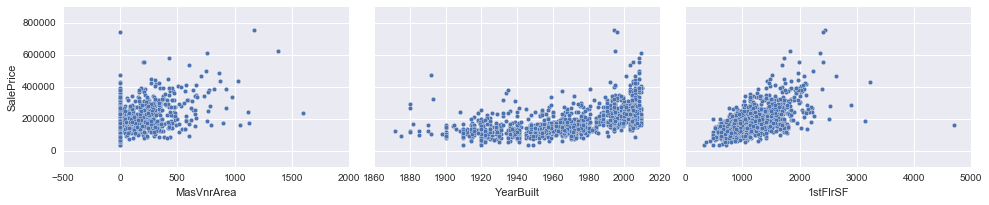

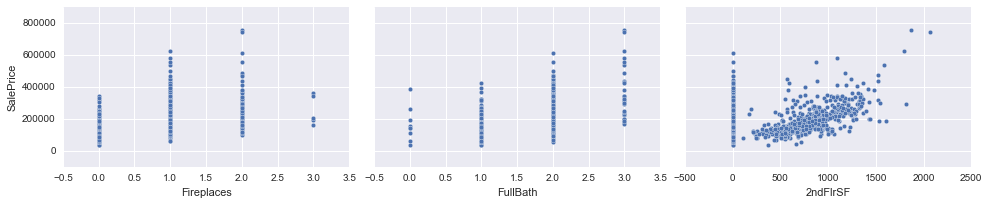

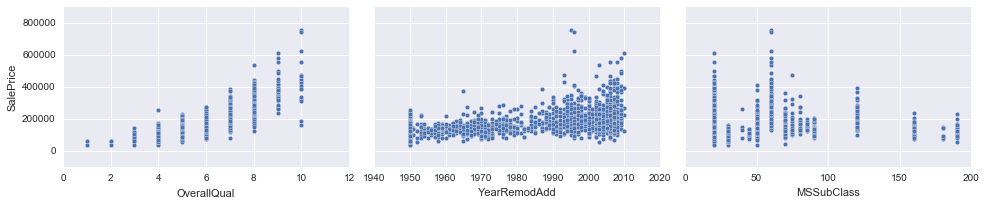

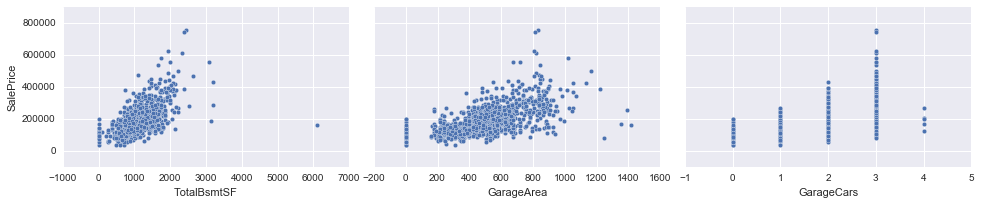

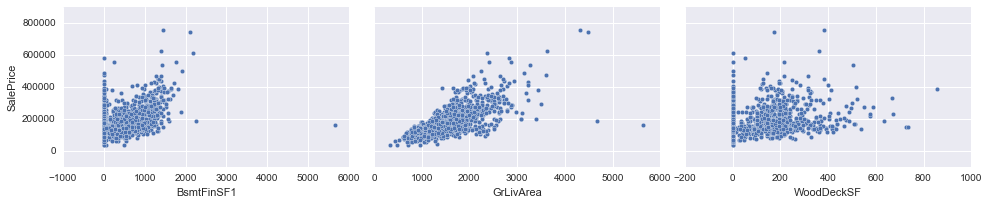

In [57]:
print "Scatter plot of the selected vairables against Sales Price"
plot_pairplots(train_df,selected_int_cols,'SalePrice',plots_perrow=3)

Boxplot of selected categorical variables against SalePrice
Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group


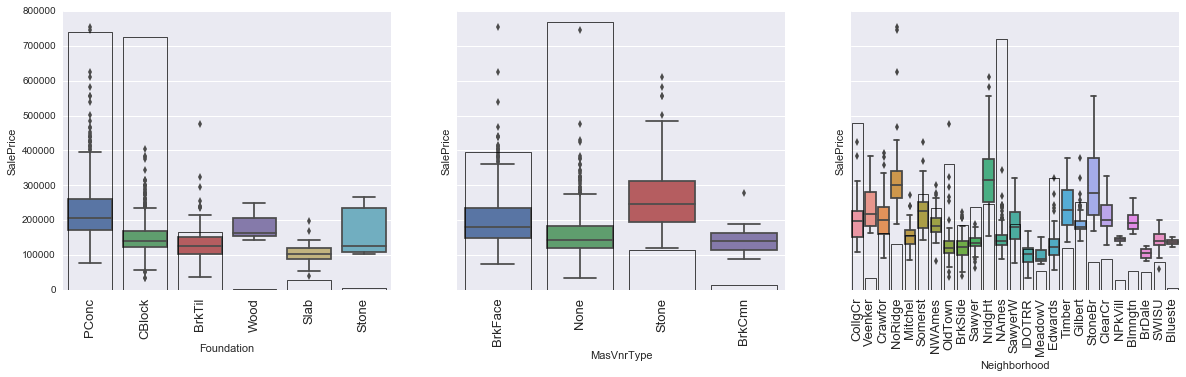

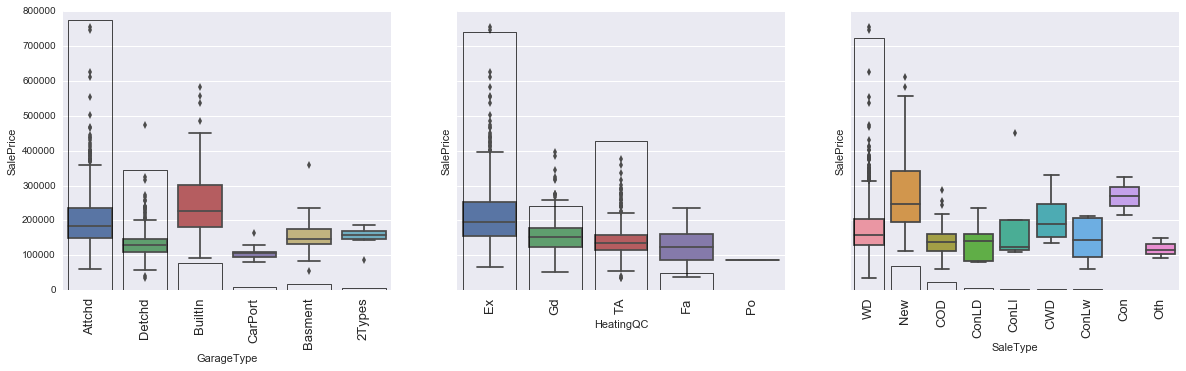

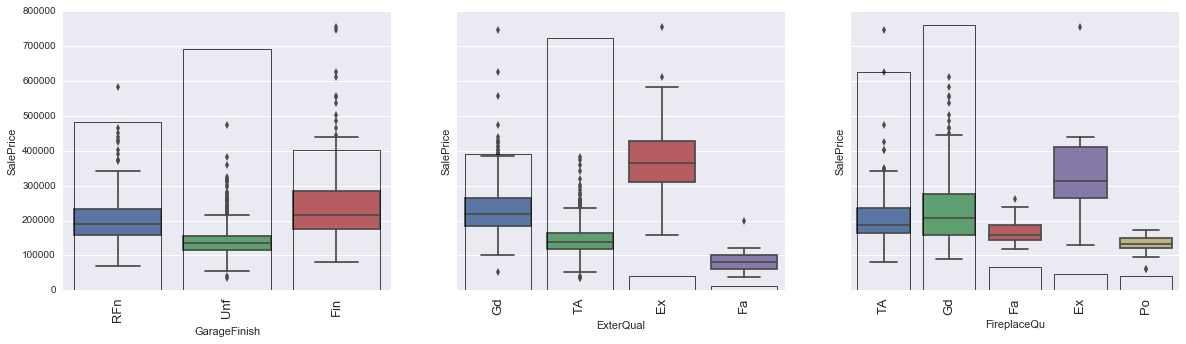

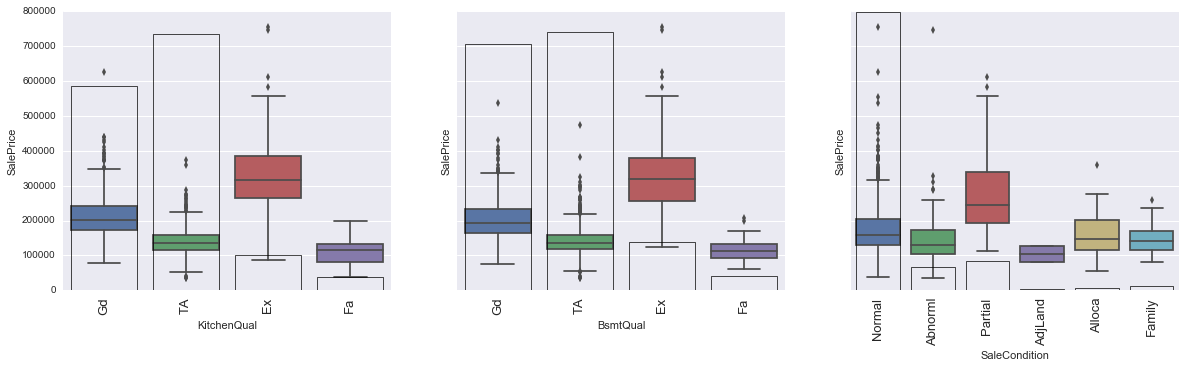

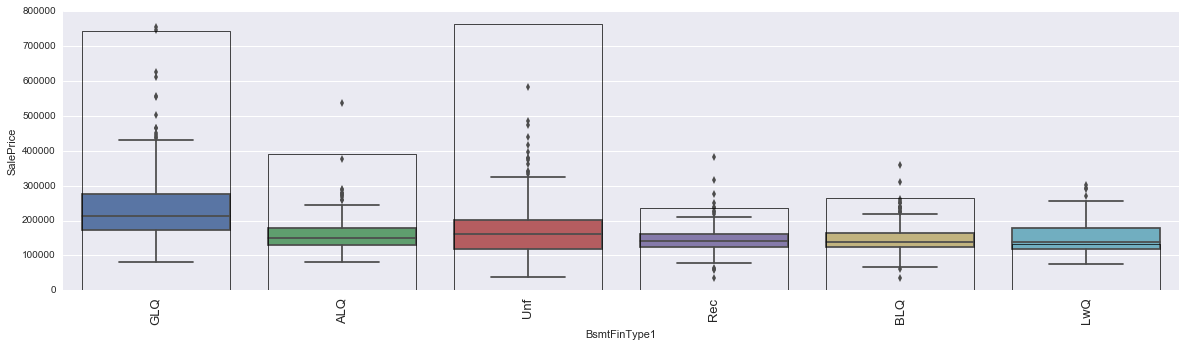

In [58]:
print "Boxplot of selected categorical variables against SalePrice"
plot_cat_graphs(train_df,selected_cat_cols,'SalePrice',plots_per_row=3,plot_type='boxplot',plot_count=True)

Built basic Ridge Regression and RandomForest model

In [60]:
# check if any of the null cols are in the selected_cols
temp_cols = set(train_null[train_null > 0].index.tolist()) & set(selected_cols_clean)
print "The following are the columns which exist in the selectedk column and are null:\n%s" %(temp_cols)

The following are the columns which exist in the selectedk column and are null:
set(['MasVnrArea', 'MasVnrType', 'GarageType', 'GarageFinish', 'FireplaceQu', 'BsmtQual', 'BsmtFinType1'])


Handle Null values in 'MasVnrArea'

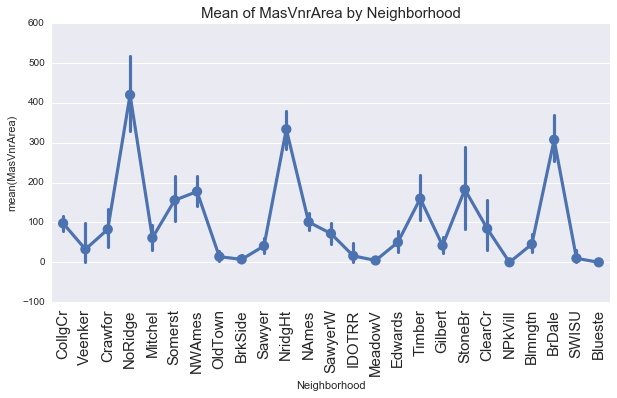

In [62]:
plt.figure(figsize=(10,5))
x=sns.pointplot('Neighborhood','MasVnrArea',data=train_df,)
x= plt.xticks(rotation='vertical',size=15)
x = plt.title("Mean of MasVnrArea by Neighborhood",size=15)

MasVnrArea value varies by Neighborhood. To fill NaNs, we use the mean of the Neighborhood 

In [68]:
# Handle missing values of MasVnrArea
train_df.loc[:,'MasVnrArea'] = train_df.groupby('Neighborhood')['MasVnrArea'].transform(lambda x:x.fillna(x.mean()))

In [69]:
train_df.MasVnrArea.isnull().sum()

0

In [70]:
train_null_cols = train_df.isnull().sum()
train_null_cols = train_null_cols[train_null_cols > 0]*100/float(len(train_df))
train_null_cols.sort_values(ascending=False)

PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageYrBlt      5.547945
GarageType       5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtFinType2     2.602740
BsmtExposure     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

We drop the those columns which have greater than 10% null values

For each variable, identify similar groups w.r.t variance on SalePrice using F Test


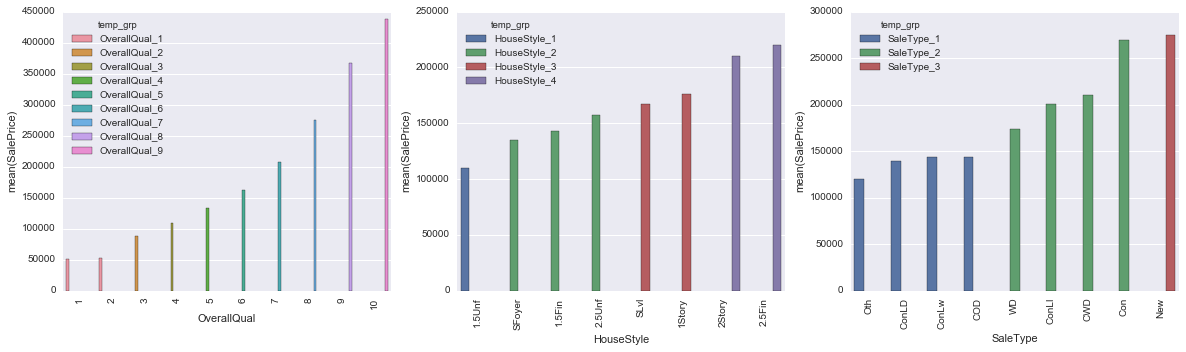

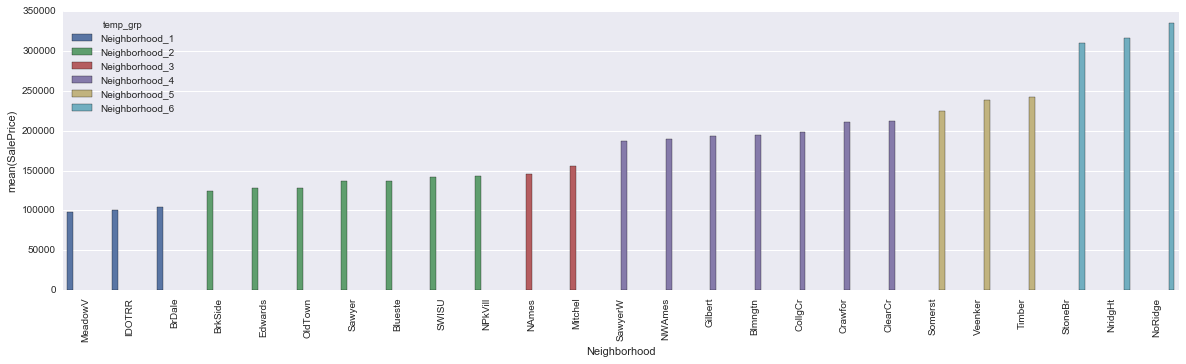

In [74]:
print "For each variable, identify similar groups w.r.t variance on SalePrice using F Test"
req_combos_lst = ['OverallQual','HouseStyle','SaleType','Neighborhood']
combos = get_combos_wraper(train_df,req_combos_lst,'SalePrice')

In [75]:
req_int_cols = int_cont_cols
req_cat_cols = str_cols + int_ordinal_cols

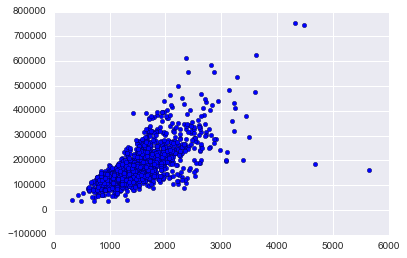

In [76]:
plt.scatter(train_df.GrLivArea,train_df.SalePrice)

Ridge Regression is susceptible to outliers, hence remove transactions where where GrLivArea is > 4000

In [77]:
# temp_int_cols = [x for x in int_cont_cols if 'SalePrice' != x]
temp_int_cols = int_cont_cols[:]
temp_int_cols = list(set(temp_int_cols) - set(null_train_cols_high))
temp_cat_cols = list(set( str_cols + int_ordinal_cols) - set(null_train_cols_high))

In [78]:
trainx,testx = generate_trans_data(train_df,test_df,temp_int_cols,temp_cat_cols)

Columns not used:['PoolQC', 'MiscFeature', 'FireplaceQu', 'Alley', 'Fence']


In [79]:
# remove outliers
trainx= trainx[trainx.GrLivArea < 4000]
train_df_filt = train_df[train_df.GrLivArea < 4000]

In [80]:
# run RandomForest
rf_clf = RandomForestRegressor(n_estimators=500,min_samples_leaf=2,n_jobs=-1,random_state=1985)
tempx,rf_clf = split_data_run_rf(train_df,trainx,'SalePrice',split_size=0.2,rf_clf=rf_clf)

The LogRMSE of prediction is:0.1586
Top 10 Feat Importance variables:
              col       val
5       GrLivArea  0.244002
353  GarageCars_3  0.200868
333  ExterQual_TA  0.131625
12    TotalBsmtSF  0.076169
16      YearBuilt  0.058129
8        1stFlrSF  0.036800
17     BsmtFinSF1  0.036148
82    BsmtQual_Ex  0.024145
22     GarageArea  0.017037
4         LotArea  0.015382


In [81]:
# get the feat_importance 
rf_feat_impt_df = pd.DataFrame(zip(trainx.drop('SalePrice',axis=1).columns,rf_clf.feature_importances_),
             columns=['variable','imp']).sort_values('imp',ascending=False)

In [96]:
# split the training data into train and testset
X_train,X_test,y_train,y_test = train_test_split(trainx.drop('SalePrice',axis=1),trainx.SalePrice,
                                                 test_size=0.2,random_state=1985)

In [97]:
len(X_train),len(X_test)

(1164, 292)

In [98]:
# run Ridge Regression
ridge_clf = Ridge(alpha=0.1,normalize=True)
ridge_clf = ridge_clf.fit(X_train,y_train)

In [99]:
# Get the coefficients
ridge_coeff = pd.DataFrame(zip(X_train.columns,ridge_clf.coef_),columns=['variable',
                                                                         'coeff']).sort_values('coeff',ascending=False)

In [100]:
ridge_coeff.head(20)

,variable,coeff
32,GarageQual_Ex,96778.614704
59,OverallQual_10,69066.595837
125,RoofStyle_Shed,52353.649856
67,OverallQual_9,37028.359455
308,Neighborhood_StoneBr,33662.153862
301,Neighborhood_NoRidge,23596.169268
157,TotRmsAbvGrd_11,21730.959243
186,SaleType_Con,20554.695747
160,TotRmsAbvGrd_14,20258.351004
323,BedroomAbvGr_8,20258.351004


In [101]:
ridge_predict = ridge_clf.predict(X_test)
rf_predict = rf_clf.predict(trainx.drop('SalePrice',axis=1))

In [102]:
print "Log RMSE is:"
print mean_squared_error(np.log(y_test),np.log(ridge_predict))**0.5

Log RMSE is:
0.137051540523


In [103]:
# get the prediction of the complete data set
ridge_predict = ridge_clf.predict(trainx.drop('SalePrice',axis=1))
rf_predict = rf_clf.predict(trainx.drop('SalePrice',axis=1))

In [104]:
temp_check = train_df_filt.copy()
temp_check['ridge_pred'] = ridge_predict
temp_check['rf_pred'] = rf_predict

In [105]:
temp_check['ridge_residual'] = temp_check.SalePrice - temp_check.ridge_pred
temp_check['rf_residual'] = temp_check.SalePrice - temp_check.rf_pred

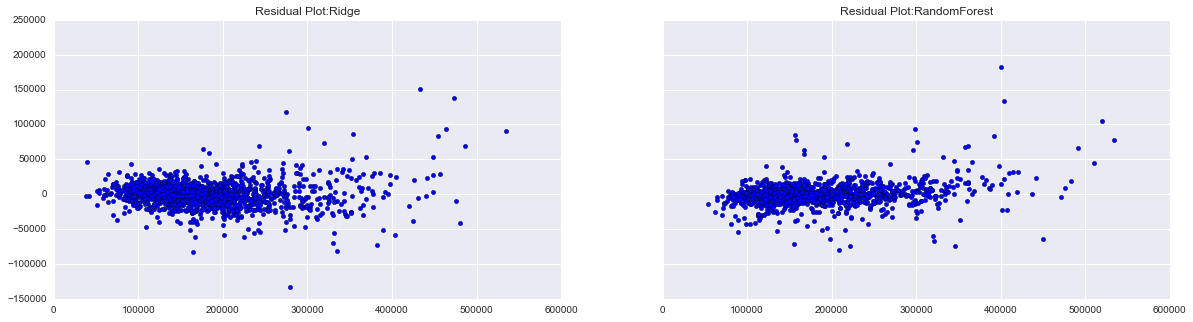

In [106]:
y,axes = plt.subplots(1,2,sharey=True,figsize=(20,5))
axes[0].scatter(temp_check.ridge_pred,temp_check.ridge_residual)
axes[0].set_title("Residual Plot:Ridge")
axes[1].scatter(temp_check.rf_pred,temp_check.rf_residual)
axes[1].set_title("Residual Plot:RandomForest")

### Feat Engineering:
#### Explore Combined GrLivArea and TotalBsmtSF

Person Correlation:
AbvGrd+Bsmt:0.779
AbvGrdSF:0.709
BsmtSF:0.614


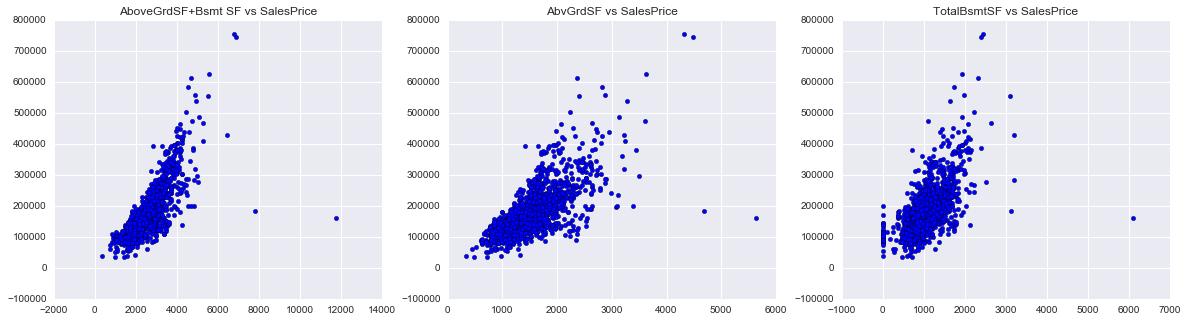

In [107]:
y,axes=plt.subplots(1,3,figsize=(20,5))
axes[0].scatter(train_df.GrLivArea + train_df.TotalBsmtSF,train_df.SalePrice)
axes[1].scatter(train_df.GrLivArea ,train_df.SalePrice)
axes[2].scatter(train_df.TotalBsmtSF,train_df.SalePrice)
axes[0].set_title("AboveGrdSF+Bsmt SF vs SalesPrice")
axes[1].set_title("AbvGrdSF vs SalesPrice")
axes[2].set_title("TotalBsmtSF vs SalesPrice")

x,y,z = (stats.pearsonr(train_df.GrLivArea + train_df.TotalBsmtSF,train_df.SalePrice)[0],
                    stats.pearsonr(train_df.GrLivArea ,train_df.SalePrice)[0],
                    stats.pearsonr(train_df.TotalBsmtSF,train_df.SalePrice)[0])
print "Person Correlation:\nAbvGrd+Bsmt:%0.3f\nAbvGrdSF:%0.3f\nBsmtSF:%0.3f" %(x,y,z)          

#### YearBuilt

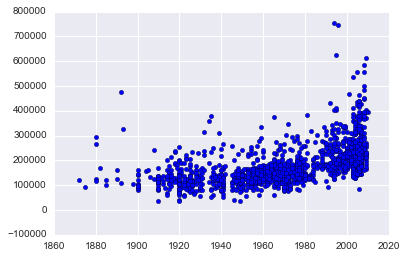

In [108]:
plt.scatter(train_df.YearBuilt,train_df.SalePrice)

Mostly, the SalePrice increases with YearBuilt,however there are outliers too..check the OverallQuality for Olderbuildings

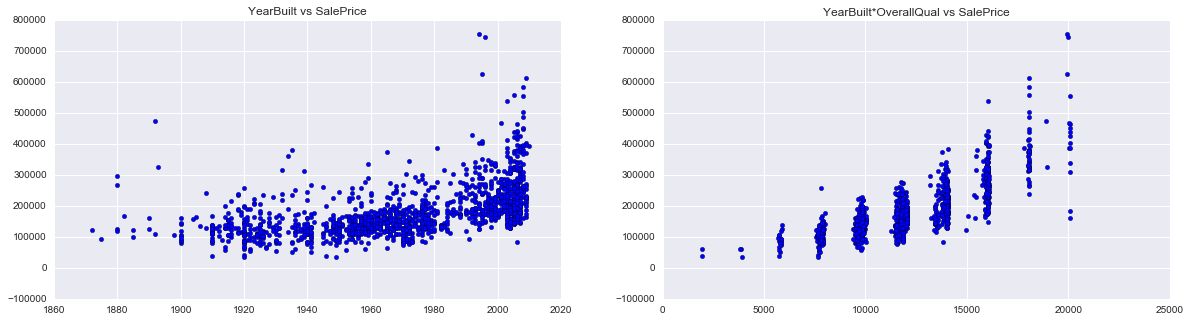

In [109]:
y,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(train_df.YearBuilt,train_df.SalePrice)
ax[1].scatter(train_df.YearBuilt*train_df.OverallQual,train_df.SalePrice)
ax[0].set_title("YearBuilt vs SalePrice")
ax[1].set_title('YearBuilt*OverallQual vs SalePrice')

In [111]:
tempx = train_df.YearBuilt * train_df.OverallQual
x = stats.pearsonr(train_df.YearBuilt,train_df.SalePrice)[0]
y = stats.pearsonr(tempx,train_df.SalePrice)[0]
print "Pearson correlation for:\n YearBuilt & SalePrice:%0.6f\n YearBuilt*Qual \
& SalePrice:%.3f\n YearBuilt*Qual**2 & SalePrice:%.3f" %(x,y,y**2)

Pearson correlation for:
 YearBuilt & SalePrice:0.522897
 YearBuilt*Qual & SalePrice:0.796
 YearBuilt*Qual**2 & SalePrice:0.634


### Explore TotalRooms and BedRooms above grade

Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group
Feat1 = TotalRooms above ground - Bedrroms
Feat2 = TotalRooms - Bedrooms - Kitchen


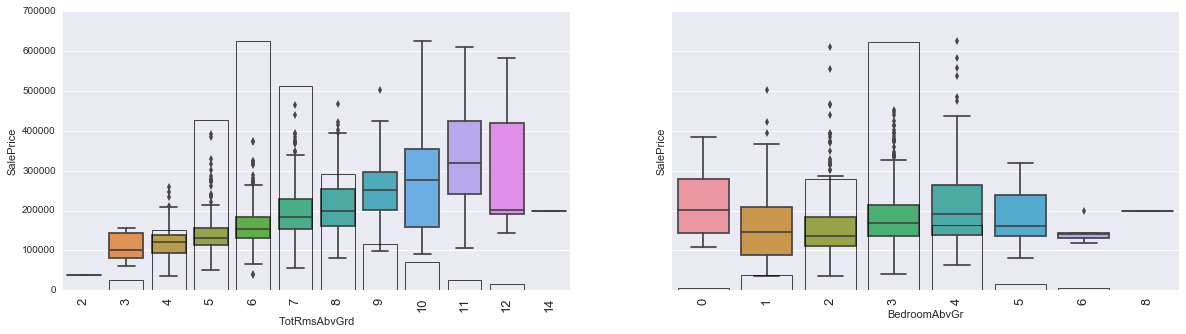

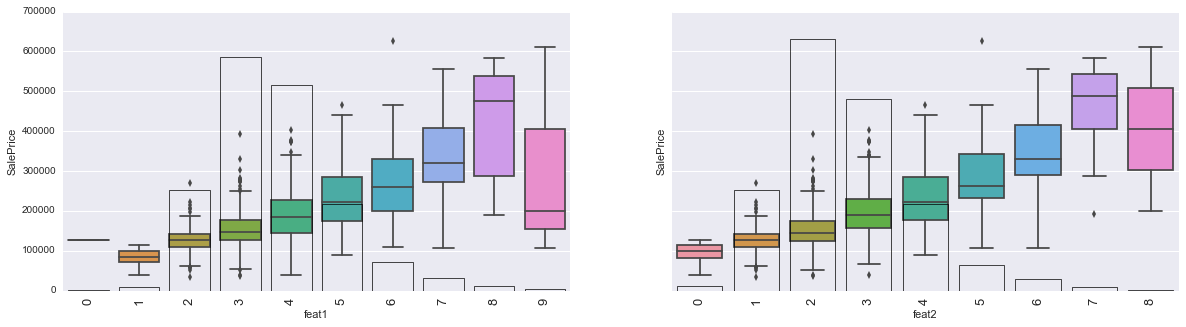

In [112]:
temp_cols = ['TotRmsAbvGrd','BedroomAbvGr','KitchenAbvGr','SalePrice','FullBath','GrLivArea','YearBuilt',
             'OverallQual','BldgType','HouseStyle']
tempx = train_df[train_df.GrLivArea < 4000][temp_cols]
tempx.loc[:,'feat1'] = tempx.TotRmsAbvGrd - tempx.BedroomAbvGr
tempx.loc[:,'feat2'] = (tempx.TotRmsAbvGrd - tempx.BedroomAbvGr - tempx.KitchenAbvGr)
plot_cat_graphs(tempx,['TotRmsAbvGrd','BedroomAbvGr','feat1','feat2'],'SalePrice',2,plot_type='boxplot',plot_count=True)

print "Feat1 = TotalRooms above ground - Bedrroms\nFeat2 = TotalRooms - Bedrooms - Kitchen"

### Explore kitchecn attributes

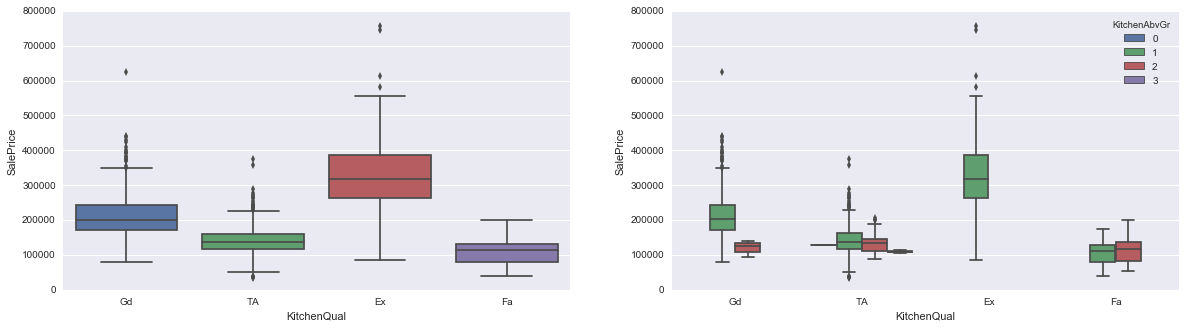

In [113]:
y,axes = plt.subplots(1,2,figsize=(20,5))
x = sns.boxplot('KitchenQual','SalePrice',data=train_df,ax = axes[0])
x = sns.boxplot('KitchenQual','SalePrice',data=train_df,hue='KitchenAbvGr',ax = axes[1])

From the graphs above, we can see that Kitchen quality plays a much signifncant than No.of Kitchens. We need to compare this with GrLivArea

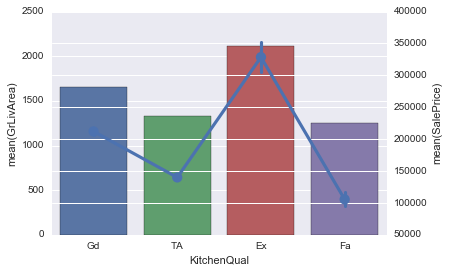

In [114]:
ax1 = sns.barplot('KitchenQual','GrLivArea',data=train_df,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
sns.pointplot('KitchenQual','SalePrice',data=train_df,ax=ax2)

The bargraph is the mean GrLivAreaSF by Kitchen quality and the line graph is the mean SalesPrice by KitchenQual.

### Explore the Heating aspects of each house sold

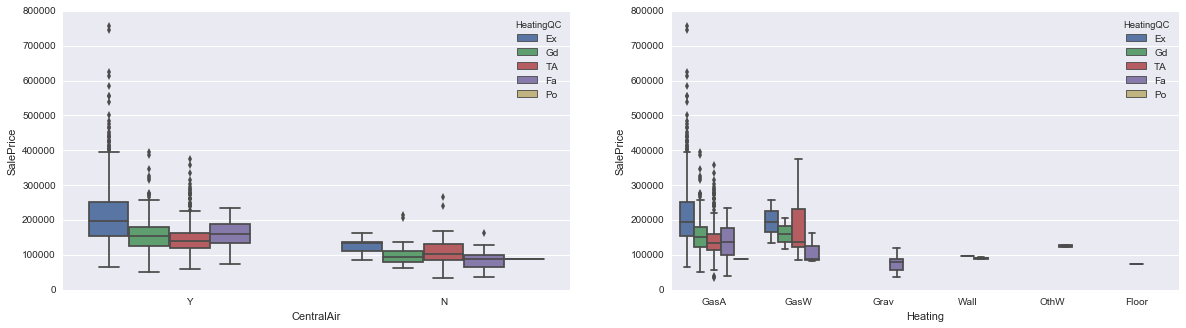

In [115]:
y,axes = plt.subplots(1,2,figsize=(20,5))
x=sns.boxplot('CentralAir','SalePrice',data=train_df,hue='HeatingQC',ax=axes[0])
x=sns.boxplot('Heating','SalePrice',data=train_df,hue='HeatingQC',ax=axes[1])

There is a different distribution of SalePrice depending on HeatingQC and CentralAir

In [116]:
heat_qual_dict = {'Ex':11,'Gd':7,'TA':7,'Fa':3,'Po':3}
central_air_dict = {'Y':20,'N':1}
tempx = zip(train_df.CentralAir.replace(central_air_dict) * train_df.HeatingQC.replace(heat_qual_dict),train_df.SalePrice)
tempx= pd.DataFrame(tempx,columns=['heating','SalePrice'])

In [117]:
# get the mean of the GrLivAreas for each tempx
tempx['mean_GrLivArea'] = train_df.groupby(tempx.heating)['GrLivArea'].transform('mean')

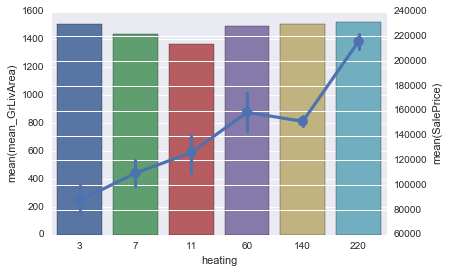

In [118]:
ax1= sns.barplot('heating','mean_GrLivArea',data=tempx)
ax2 = ax1.twinx()
ax1 = sns.pointplot('heating','SalePrice',data=tempx,ax=ax2)

The bargraphs is the mean GrLivArea SF for each heating combination. The line graph is the mean SalePrice of each heating type(combination of CentralAir and Heating Qual). Clearly the type of heating impacts the SalePrice

### Explore the Impact of Garage attributes on the SalePrice

GarageAttributes - GarageType,GarageYrBlt, GarageFinish, GarageCars, Garage Area, GarageQual, GarageCond

In [119]:
train_df[['GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond']].apply(lambda x:x.unique().tolist())

GarageType      [Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...
GarageFinish                                 [RFn, Unf, Fin, nan]
GarageCars                                        [2, 3, 1, 0, 4]
GarageQual                              [TA, Fa, Gd, nan, Ex, Po]
GarageCond                              [TA, Fa, nan, Gd, Po, Ex]
dtype: object

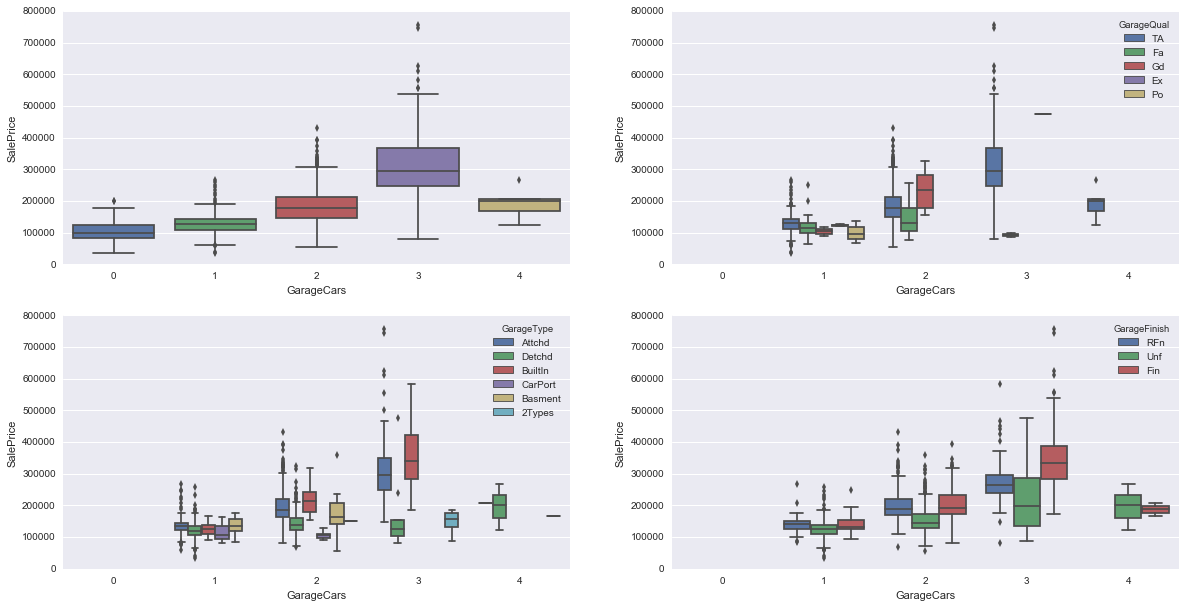

In [120]:
y,axes = plt.subplots(2,2,figsize=(20,10))
sns.boxplot('GarageCars','SalePrice',data=train_df,ax=axes[0][0])
sns.boxplot('GarageCars','SalePrice',data=train_df,hue='GarageQual',ax=axes[0][1])
sns.boxplot('GarageCars','SalePrice',data=train_df,ax=axes[1][0],hue='GarageType')
sns.boxplot('GarageCars','SalePrice',data=train_df,hue='GarageFinish',ax=axes[1][1])

From the Above plots we conclude the following:

    1) GarageCars can act as a proxy for GarageArea
    2) Sales Price is dependent on the GarageType,GarageCars and GarageFinish
    3) For GarageFinish, we can combine RFn and Fin

In [121]:
gr_finish_dict = {'RFn':1,'Fin':1,'Unf':0.1}
gr_type_dict = {'Attchd':1,'BuiltIn':1,'Detchd':.01,'CarPort':.01,'Basment':.01,'2Types':.01,np.nan:0}

In [125]:
# create a temp dataset for plot
tempx = train_df[['SalePrice','GrLivArea','GarageFinish','GarageType','GarageCars','GarageArea']]
for xcol,xdict in [('GarageFinish',gr_finish_dict),('GarageType',gr_type_dict)]:
    tempx.loc[:,xcol] = tempx[xcol].replace(xdict)

tempx.loc[:,'Garage'] = ((tempx.GarageCars**3) * tempx.GarageFinish * tempx.GarageType).round(1)

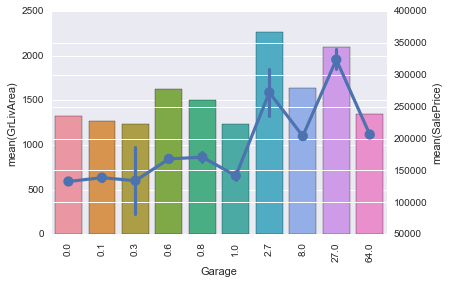

In [126]:
xaxis_order = tempx.groupby('Garage')['GrLivArea'].mean().sort_values().index.tolist()
ax1 = sns.barplot('Garage','GrLivArea',data=tempx,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
x=sns.pointplot('Garage','SalePrice',data=tempx,ax=ax2)
x=plt.setp(ax1.get_xticklabels(),rotation='vertical')

The bar graph represents the mean Above Ground Living Area in SF and the line graph the mean SalesPrice.

In the above graph, we can see that the mean sales price for each group of Garge(x-axis) does not proportionaly follow the increases of mean_GrLivArea.

### Eplore the impact of Basement
Basements related variables: BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2, BsmtFinSF2, BsmtUnSF,TotalBsmtSF

Thar bar grpah represents the count of xaxis groups in the data.This gives an idea of the frequency of the group


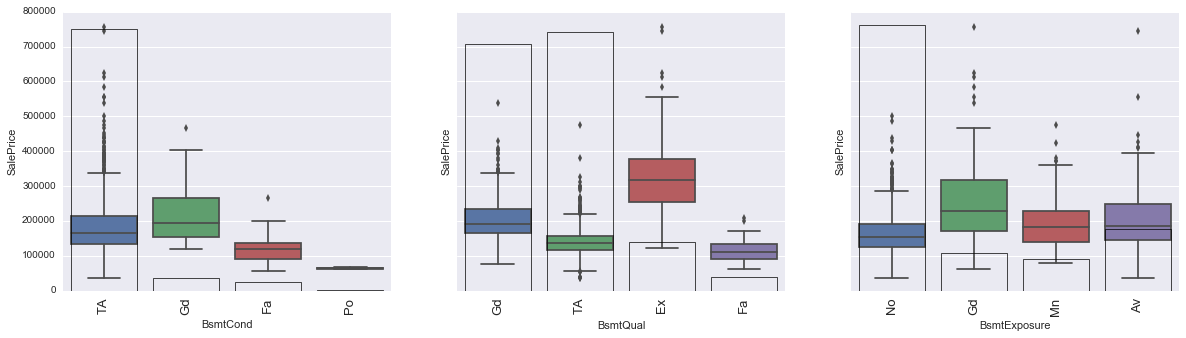

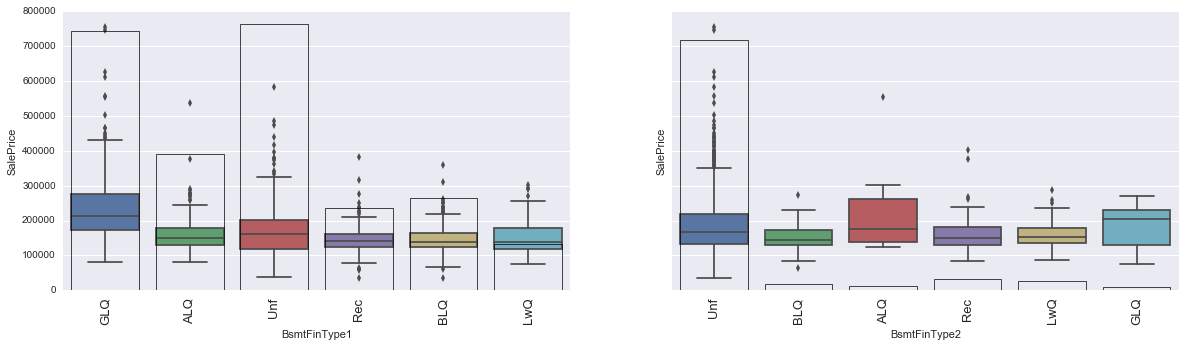

In [135]:
plot_cat_graphs(train_df,['BsmtCond','BsmtQual','BsmtExposure','BsmtFinType1','BsmtFinType2'],'SalePrice',
                plots_per_row=3, plot_type='boxplot',plot_count=True)

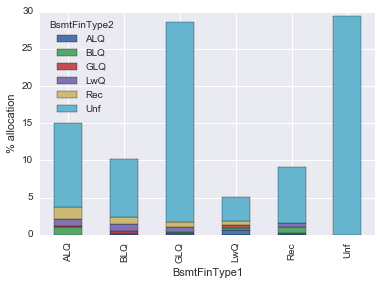

In [136]:
(train_df.groupby(['BsmtFinType1','BsmtFinType2']).size()*100/float(len(train_df))).unstack().plot(kind='bar',stacked=True)
x= plt.ylabel('% allocation')

From the above graph we can see that FinType2 is mostly Unf (unfinished)

In [137]:
# train_df.groupby('BsmtFinType1')['SalePrice'].median().sort_values()

In [138]:
bsmt_qual_dict ={'Ex':23,'Gd':7,'TA':1,'Fa':1,np.nan:0}
bsmt_exp = {'Gd':3,'No':1,'Mn':1,'Av':1,'No':1,np.nan:0}
bsmt_fintype1 = {'GLQ':1,'ALQ':1,'Unf':1,'Rec':1,'BLQ':1,'LwQ':1,np.nan:0}

In [139]:
tempx = train_df.BsmtQual.replace(bsmt_qual_dict) * train_df.BsmtExposure.replace(bsmt_exp) * \
                                            train_df.BsmtFinType1.replace(bsmt_fintype1)
tempx = pd.DataFrame(zip(tempx,train_df.SalePrice,train_df.TotalBsmtSF,
                         train_df.GrLivArea),columns=['bsmt','SalePrice','TotalBsmtSF','GrLivArea'])

In [140]:
tempx['mean_GrLivArea'] = tempx.groupby('bsmt')['GrLivArea'].transform('mean')

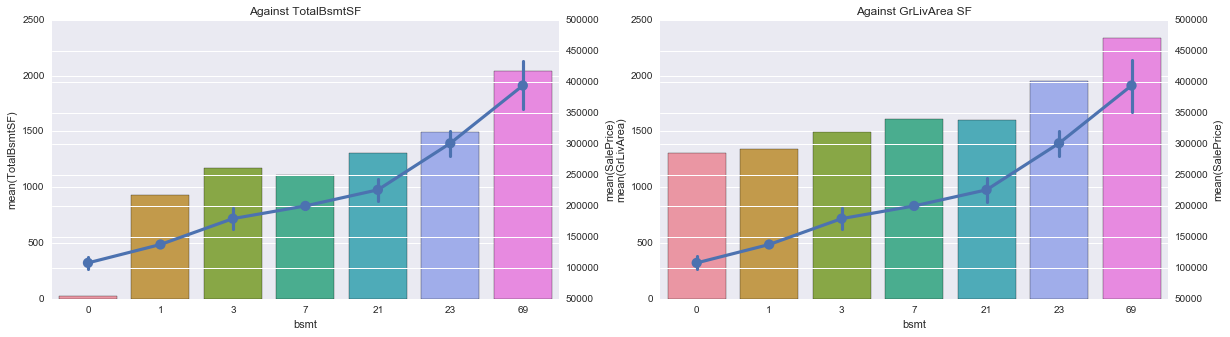

In [141]:
y,axes = plt.subplots(1,2,figsize=(20,5))
sns.barplot('bsmt','TotalBsmtSF',data=tempx,estimator=np.mean,ci=None,ax=axes[0])
ax02 = axes[0].twinx()
sns.pointplot('bsmt','SalePrice',data=tempx,ax=ax02)

sns.barplot('bsmt','GrLivArea',data=tempx,estimator=np.mean,ci=None,ax=axes[1])
ax12 = axes[1].twinx()
sns.pointplot('bsmt','SalePrice',data=tempx,ax=ax12)
axes[0].set_title('Against TotalBsmtSF')
axes[1].set_title('Against GrLivArea SF')

From the abpve graphs we can see that there is interaction terms with certain bsmt features. Also, we can see that the GrLivArea has a greater weightage than bsmt

### Explore the impact of Fireplaces

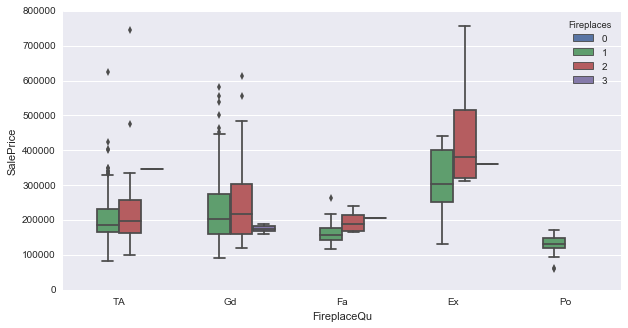

In [142]:
plt.figure(figsize=(10,5))
sns.boxplot('FireplaceQu','SalePrice',data=train_df,hue='Fireplaces')

In [143]:
fire_qual_dict= {'Ex':17,'Gd':4,'TA':4,'Fa':1,'Po':1,np.nan:0}
tempx = train_df.Fireplaces * train_df.FireplaceQu.replace(fire_qual_dict)
tempx = pd.DataFrame(zip(tempx,train_df.SalePrice,train_df.GrLivArea),columns=['fire','SalePrice','GrLivArea'])

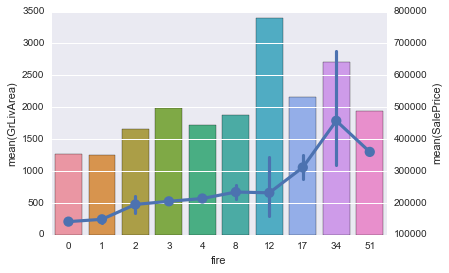

In [144]:
ax1 = sns.barplot('fire','GrLivArea',data=tempx,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
x =sns.pointplot('fire','SalePrice',data=tempx,ax=ax2)

### Explore SaleType and SaleCondition

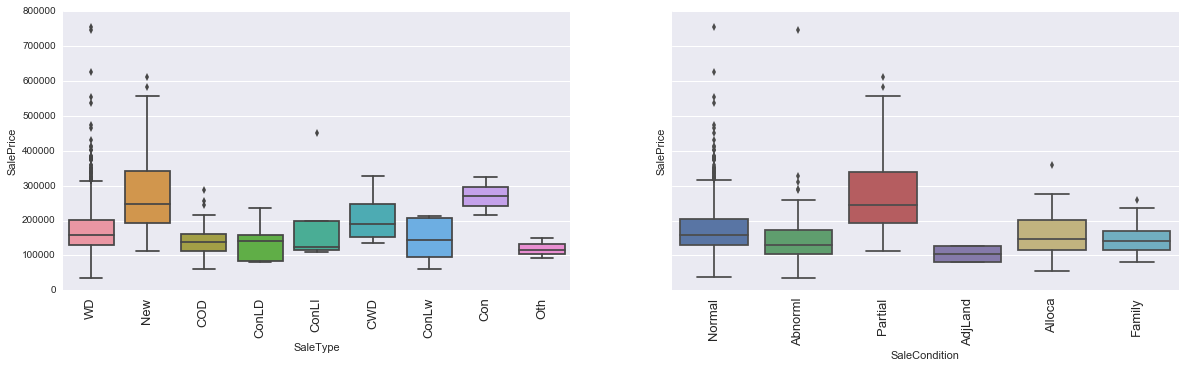

In [145]:
plot_cat_graphs(train_df,['SaleType','SaleCondition'],'SalePrice',plots_per_row=3,plot_type='boxplot')

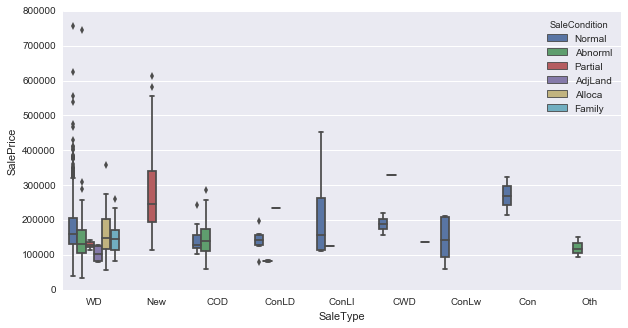

In [146]:
plt.figure(figsize=(10,5))
sns.boxplot('SaleType','SalePrice',data=train_df,hue='SaleCondition')

From the above graph, we only need a boolean if the SaleTye is New or not

### Explore Exterior Conditions

'RoofStyle','RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType','MasVnrArea', 'ExterQual', 'ExterCond','Foundation'

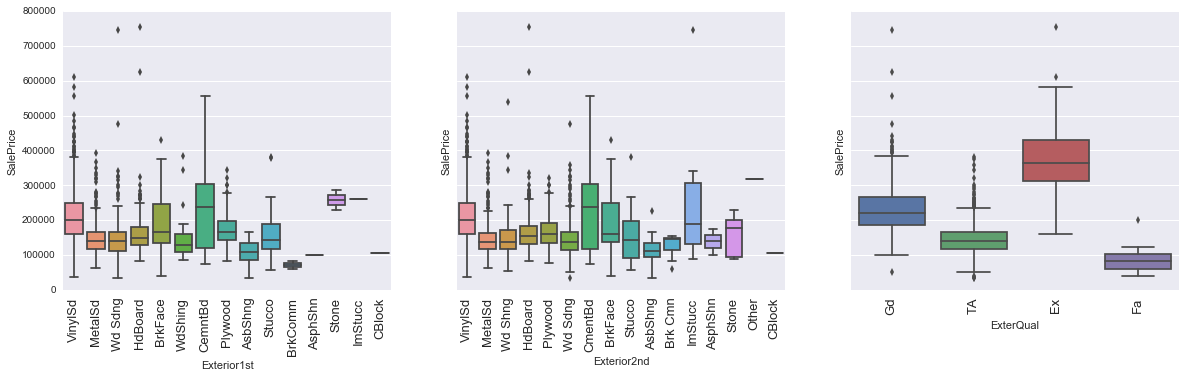

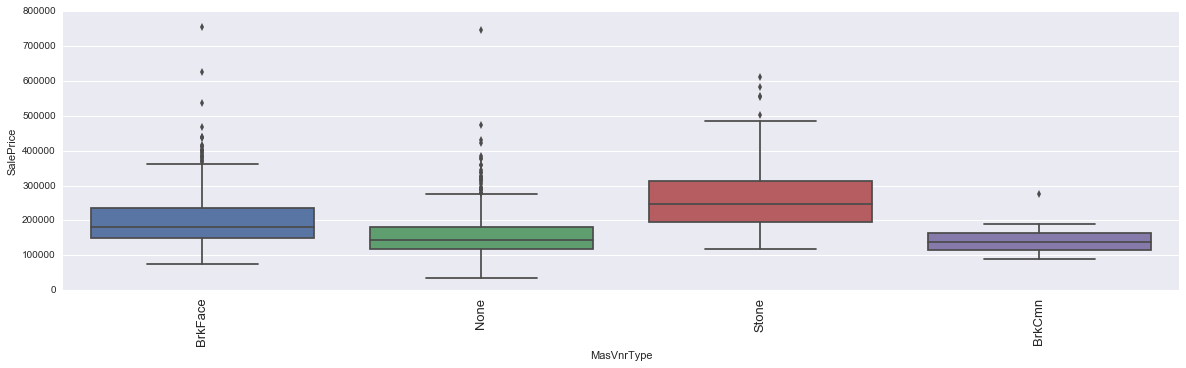

In [147]:
plot_cat_graphs(train_df,['Exterior1st','Exterior2nd','ExterQual','MasVnrType'],'SalePrice',plots_per_row=3,plot_type='boxplot')

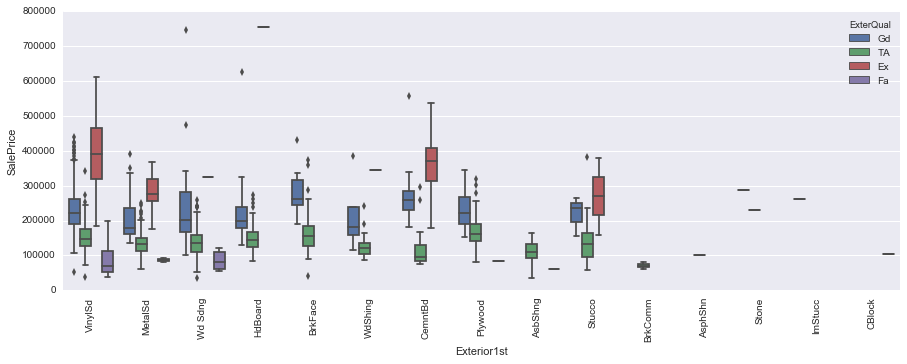

In [148]:
plt.figure(figsize=(15,5))
x = sns.boxplot('Exterior1st','SalePrice',data=train_df,hue='ExterQual')
x = plt.xticks(rotation='vertical')

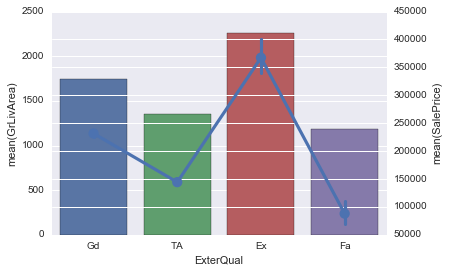

In [149]:
ax1 = sns.barplot('ExterQual','GrLivArea',data=train_df,estimator=np.mean,ci=None)
ax2 = ax1.twinx()
sns.pointplot('ExterQual','SalePrice',data=train_df,ax=ax2)

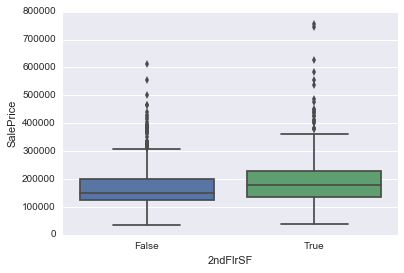

In [150]:
sns.boxplot(train_df['2ndFlrSF'] >0,train_df.SalePrice)

#### Build the required features

In [151]:
combined_df = pd.concat([train_df,test_df],ignore_index=True).loc[:,train_df.columns]

In [152]:
# set Id as index
combined_df = combined_df.set_index('Id',drop=False)

In [153]:
# dicts for garage Type. We keep Garage Cars as it is
gr_fin_dict={'Fin':1,'RFn':1,'Unf':0,np.nan:0}
gr_type_dict ={'2Types': 0, 'Attchd': 1, 'Basment': 0, 'BuiltIn': 1, 'CarPort': 0, 'Detchd': 0,np.nan:0}
xcolos_dict = [('GarageFinish',gr_fin_dict),('GarageType',gr_type_dict)]
for col,xdict in xcolos_dict:
    print combined_df[col].unique()
    combined_df.loc[:,col] = combined_df[col].replace(xdict)
    print combined_df[col].unique()
    

['RFn' 'Unf' 'Fin' nan]
[1 0]
['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
[1 0]


In [154]:
# dict for Kitchen
kitchenqual_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':1,np.nan:0}
combined_df.loc[:,'KitchenQual'] = combined_df.KitchenQual.replace(kitchenqual_dict)
combined_df.KitchenQual.unique()

array([4, 3, 5, 1, 0], dtype=int64)

In [155]:
# dict for Central air
heat_qual_dict = {'Ex':11,'Gd':7,'TA':7,'Fa':3,'Po':3}
central_air_dict = {'Y':20,'N':1}
# For heating we create a feat which is a product of central air and heatquality
combined_df['feat_heat'] = combined_df.HeatingQC.replace(heat_qual_dict) * combined_df.CentralAir.replace(central_air_dict)
combined_df.feat_heat.unique()

array([220, 140,   3,   7,  11,  60], dtype=int64)

In [156]:
# dict for Bsmt
bsmt_qual_dict ={'Ex':23,'Gd':7,'TA':1,'Fa':1,np.nan:0}
bsmt_exp = {'Gd':3,'No':1,'Mn':1,'Av':1,'No':1,np.nan:0}
# We create a feat_bsmt column as a multiple of the above two
combined_df['feat_bsmt'] = combined_df.BsmtQual.replace(bsmt_qual_dict) * combined_df.BsmtExposure.replace(bsmt_exp)
print combined_df['feat_bsmt'].unique()

[ 7 21  1 23  0  3 69]


In [157]:
# dicts for Fireplace
fire_qual_dict = {np.nan: 0, 'Ex': 17, 'Fa': 1, 'Gd': 4, 'Po': 1, 'TA': 4}
# we create a feat_fire column . product of quality and fireplaces
combined_df['feat_fire'] = combined_df.FireplaceQu.replace(fire_qual_dict) * combined_df.Fireplaces
print combined_df.feat_fire.unique()

[ 0  4  8  1 17 12  2 51 34  3 16]


In [158]:
# Create Total SF feature.
combined_df['feat_totalSF'] = ((combined_df.GrLivArea + combined_df.TotalBsmtSF)**2) * combined_df.OverallQual

In [159]:
# set feat for SaleType...check 
combined_df.loc[:,'SaleType'] = (combined_df.SaleType == 'New').astype(int)

In [160]:
# bed bath ratio
combined_df.loc[:,'feat_bed_bath_ratio'] = ((combined_df.FullBath/combined_df.BedroomAbvGr).replace(np.inf,0) >= 1).astype(int)

In [161]:
# feat_YearBuilt_Qual
combined_df.loc[:,'feat_YrBuiltQual'] = combined_df.YearBuilt * combined_df.OverallQual

In [162]:
# Rooms Features
combined_df.loc[:,'feat_rooms'] = combined_df.TotRmsAbvGrd - combined_df.BedroomAbvGr - combined_df.KitchenAbvGr

In [163]:
# # dict for MSSubClass
# xdict = get_combos_wraper(train_df,['MSSubClass'],'SalePrice')
# mssubclass_dict = dict(xdict)['MSSubClass']
# mssubclass_dict = dict([(a,int(b.split('_')[1])) for a,b in mssubclass_dict])
# combined_df.loc[:,'MSSubClass'] = combined_df.MSSubClass.replace(mssubclass_dict)

In [164]:
# xdict = get_combos_wraper(train_df,['YearBuilt'],'SalePrice')

# yrbuild_dict = dict(xdict)['YearBuilt']
# yrbuild_dict = dict([(a,int(b.split('_')[1])) for a,b in yrbuild_dict])
# combined_df.loc[:,'YearBuilt'] = combined_df.YearBuilt.replace(yrbuild_dict)

In [171]:
# create a list of all the feat cols
feat_int_cols = ['feat_bsmt','feat_fire','feat_heat','feat_totalSF','feat_bed_bath_ratio','feat_YrBuiltQual','feat_rooms']

In [172]:
xtrain_df = combined_df[combined_df.Id.isin(train_df.Id.unique().tolist())]
xtest_df = combined_df[combined_df.Id.isin(test_df.Id.unique().tolist())]

In [173]:
# Filter outliers based on LivArea
xtrain_df = xtrain_df[xtrain_df.GrLivArea < 4000]

In [174]:
xtest_df.shape, xtrain_df.shape

((1459, 88), (1456, 88))

In [175]:
temp_req_cols = ['feat_totalSF','feat_heat','feat_bsmt','feat_fire','GarageCars','KitchenQual','YearBuilt',
                 'SalePrice','SaleType','BedroomAbvGr','FullBath','HalfBath']
# temp_shift_cols = ['MSSubClass','FullBath']
temp_int_ordinal_cols = int_ordinal_cols[:]
temp_req_ordinal_cols = []
temp_int_ordinal_cols = list(set(temp_int_ordinal_cols) - set(temp_req_ordinal_cols))
temp_int_cols = int_cont_cols + feat_int_cols + temp_int_ordinal_cols
temp_cat_cols =  str_cols  + temp_req_ordinal_cols
xtrain_trans_df,xtest_trans_df = generate_trans_data(xtrain_df,xtest_df,temp_int_cols,temp_cat_cols)

In [176]:
all(xtrain_df.index == xtrain_trans_df.index)

True

In [177]:
rf_clf= RandomForestRegressor(n_estimators=400,min_samples_leaf=2,n_jobs=-1,random_state=1985,)

In [183]:
temp_df, rf_clf = split_data_run_rf(xtrain_df,xtrain_trans_df,'SalePrice',split_size=0,rf_clf=rf_clf,top_feat=20)

The LogRMSE of prediction is:0.0628
Top 10 Feat Importance variables:
                  col       val
38       feat_totalSF  0.801535
42   feat_YrBuiltQual  0.029980
23          feat_bsmt  0.015724
17       YearRemodAdd  0.013228
7             LotArea  0.008934
30          YearBuilt  0.008669
2           BsmtUnfSF  0.007974
32         BsmtFinSF1  0.007892
40         GarageArea  0.007487
8           GrLivArea  0.006034
25         feat_rooms  0.004999
31        GarageYrBlt  0.004388
41         GarageCars  0.004120
6         OverallCond  0.003634
11           1stFlrSF  0.003561
13        LotFrontage  0.003384
9          WoodDeckSF  0.002855
3         OpenPorchSF  0.002848
20        TotalBsmtSF  0.002846
233     KitchenQual_3  0.002775


In [184]:
temp_df.rename(columns={'residual':'orig_residual'},inplace=True)

In [185]:
temp_df['prediction1'] = temp_df.predicted

#### Create a model to train on the residuals

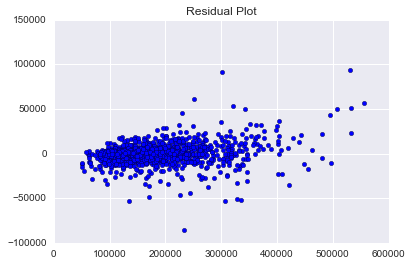

In [187]:
plt.scatter(temp_df.predicted, temp_df.orig_residual)
plt.title("Residual Plot")

In [188]:
temp_trans_df = xtrain_trans_df.copy()
temp_trans_df['orig_residual'] = temp_df.orig_residual
del temp_trans_df['SalePrice']

In [189]:
rf_clf_residual = RandomForestRegressor(n_estimators=300,n_jobs=-1,min_samples_leaf=2,random_state=1985)
tempy,rf_clf_residual = split_data_run_rf(temp_df,temp_trans_df,'orig_residual',0,rf_clf_residual,getscore=False)

Top 10 Feat Importance variables:
                     col       val
7                LotArea  0.081234
38          feat_totalSF  0.069831
20           TotalBsmtSF  0.055618
2              BsmtUnfSF  0.054746
8              GrLivArea  0.049659
40            GarageArea  0.039305
11              1stFlrSF  0.035703
13           LotFrontage  0.029967
77  Neighborhood_Crawfor  0.028964
32            BsmtFinSF1  0.027095


In [190]:
tempy['prediction2'] = tempy.prediction1 + tempy.predicted

In [191]:
all(tempy.index == temp_df.index)

True

In [192]:
mean_squared_error(np.log(tempy.SalePrice),np.log(tempy.prediction2))**0.5

0.028099830327765637

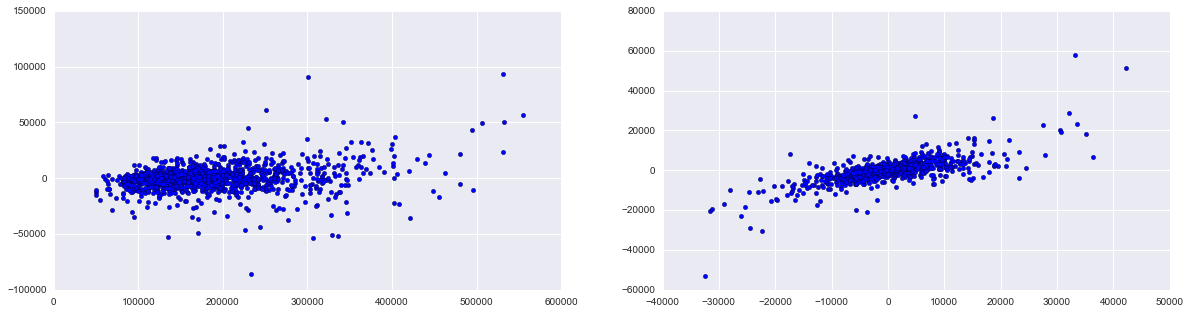

In [193]:
y,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(temp_df.predicted,temp_df.orig_residual)
ax[1].scatter(tempy.predicted,tempy.residual)

In [194]:
xtrain_trans_df.shape, xtest_trans_df.shape, test_df.shape, temp_trans_df.shape

((1456, 283), (1459, 282), (1459, 80), (1456, 283))

Predict SalePrice for the Testset

In [195]:
pred1 = rf_clf.predict(xtest_trans_df)
pred2 = rf_clf_residual.predict(xtest_trans_df)

In [196]:
pred = pred1 + pred2

In [197]:
pred_df = pd.DataFrame(zip(test_df.Id, pred),columns=['Id','SalePrice'])

In [198]:
pred_df.to_csv(loc_dir + '/output/test8.csv',index=False)

TODO: Explore features such as SF of each room, hyperparameter tuning using seach grid

# Misc

In [348]:
# plt.hist(pred2), plt.hist(pred1)

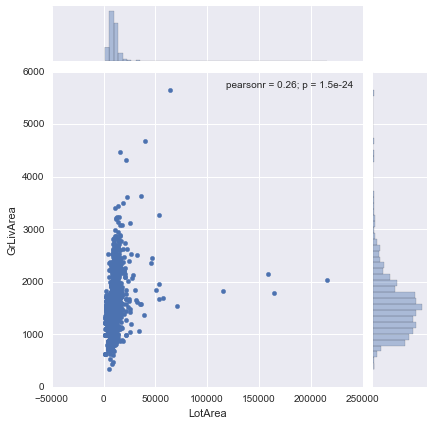

In [362]:
sns.jointplot(train_df.LotArea,train_df.GrLivArea)

In [367]:
temp_df.GarageFinish.unique(), temp_df.GarageType.unique()

(array([1, 0], dtype=int64), array([1, 0], dtype=int64))

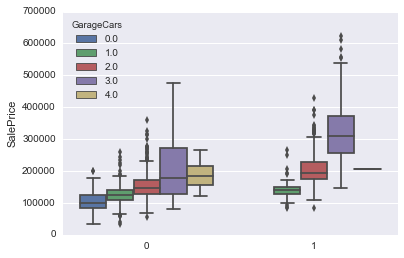

In [369]:
sns.boxplot(temp_df.GarageFinish * temp_df.GarageType, temp_df.SalePrice,hue=temp_df.GarageCars)

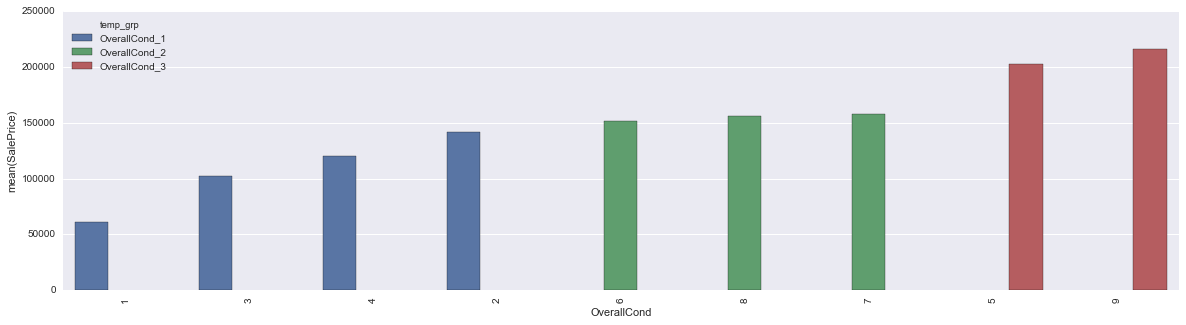

In [391]:
x = get_combos_wraper(temp_df,['OverallCond'],'SalePrice')

In [405]:
xdict = dict([(a,int(b.split('_')[1])) for (a,b) in dict(x)['OverallCond']])

In [407]:
xdict = {1: 11, 2: 11, 3: 11, 4: 11, 5: 17, 6: 13, 7: 13, 8: 13, 9: 17}

In [408]:
tempx = temp_df.OverallCond.replace(xdict)

In [409]:
tempx.value_counts()

17    840
13    528
11     88
Name: OverallCond, dtype: int64

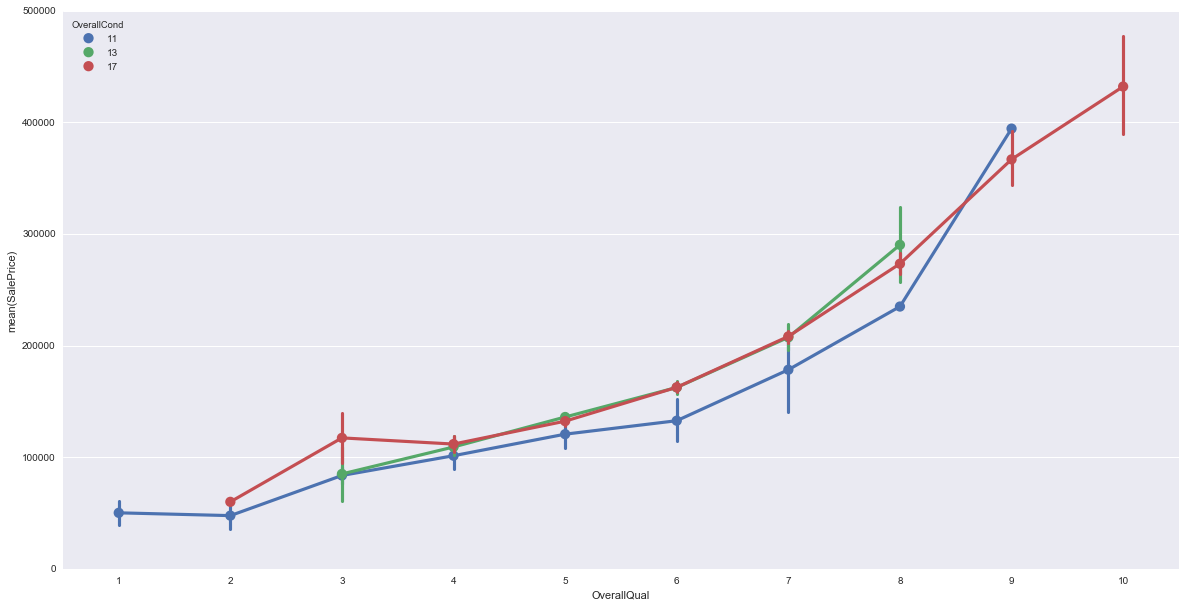

In [415]:
plt.figure(figsize=(20,10))
sns.pointplot(temp_df.OverallQual,temp_df.SalePrice,hue=tempx)

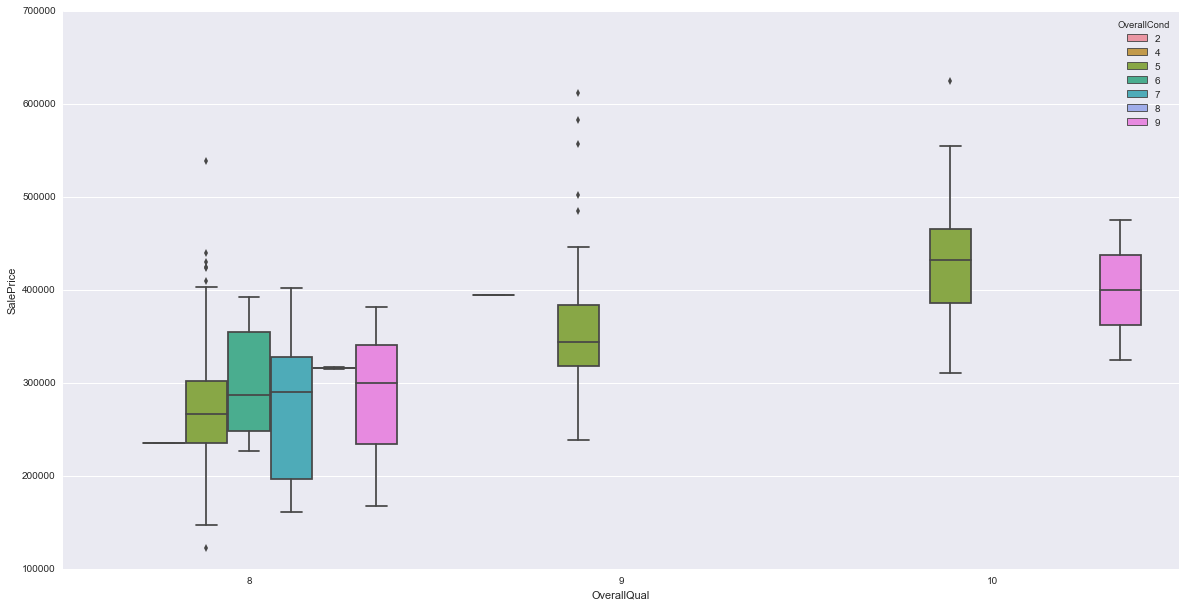

In [417]:
plt.figure(figsize=(20,10))
sns.boxplot('OverallQual','SalePrice',data=temp_df[temp_df.OverallQual >7],hue='OverallCond')

In [428]:
temp_df[temp_df.OverallQual == 9].groupby('OverallCond').agg({'GrLivArea':'mean','SalePrice':'mean',
                                                              'feat_totalSF':'mean','KitchenQual':'mean'})

,feat_totalSF,GrLivArea,SalePrice,KitchenQual
OverallCond,,,,
2,1.240105e+08,1856.000000,394432.000000,5.000000
5,1.331178e+08,2082.785714,366872.095238,4.809524


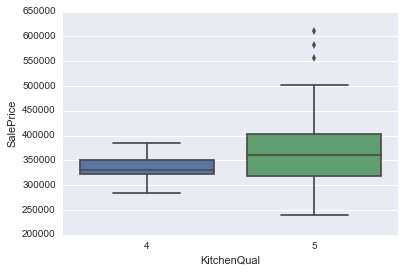

In [430]:
temp_bool = temp_df.OverallQual ==9
sns.boxplot('KitchenQual','SalePrice',data=temp_df[temp_bool])

In [422]:
temp_df[temp_df.OverallQual == 9]

5    42
2     1
Name: OverallCond, dtype: int64

In [374]:
temp_df.MSZoning.value_counts(dropna)

RL         1147
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [256]:
temp_bool = temp_df.orig_residual.abs()>40000
temp_df[temp_bool]['OverallQual'].value_counts()

8     8
7     4
9     2
6     2
10    1
Name: OverallQual, dtype: int64

In [ ]:
temp_bool = 

In [254]:
temp_df[temp_df.orig_residual.abs()>40000][int_ordinal_cols + ['orig_residual']].sort_values('orig_residual')

,MSSubClass,OverallQual,OverallCond,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,MoSold,GarageCars,Fireplaces,FullBath,BsmtFullBath,BsmtHalfBath,HalfBath,orig_residual
Id,,,,,,,,,,,,,,
1325,20,8,5,2,1,7,2,3.0,1,2,0.0,0.0,0,-84904.766879
333,20,8,5,3,1,7,10,3.0,1,2,1.0,0.0,0,-57933.336268
1045,20,8,5,4,1,9,7,2.0,1,2,1.0,0.0,1,-55212.305292
582,20,8,5,3,1,8,8,3.0,1,2,0.0,0.0,1,-54236.270115
633,20,7,5,3,1,6,4,2.0,1,2,0.0,0.0,0,-50169.741875
67,20,7,5,3,1,7,7,2.0,1,2,1.0,0.0,0,-48453.824494
636,190,6,7,8,2,14,3,0.0,0,2,0.0,0.0,0,-46763.720872
1350,70,8,5,4,1,8,12,0.0,0,2,0.0,0.0,0,-43363.758667
1424,80,6,7,4,1,8,8,2.0,1,2,0.0,0.0,0,40248.625575


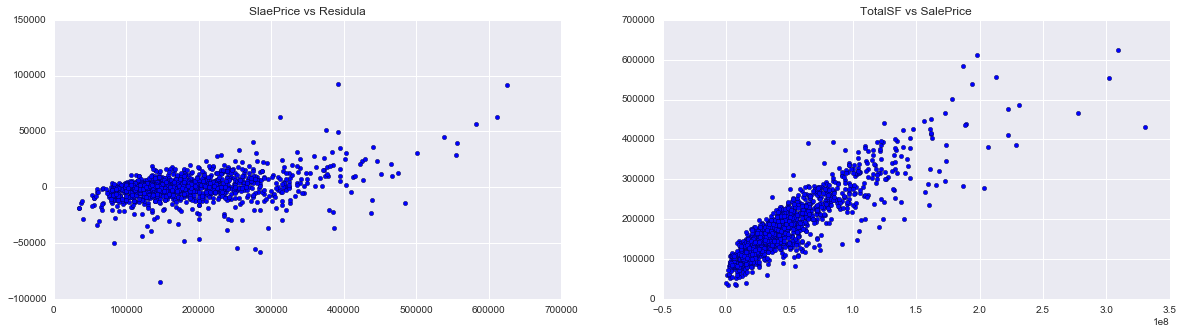

In [230]:
y,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(temp_df.SalePrice,temp_df.orig_residual)
ax[1].scatter(temp_df.feat_totalSF,temp_df.SalePrice)
ax[0].set_title("SlaePrice vs Residula")
ax[1].set_title("TotalSF vs SalePrice")